In [1]:
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier

#load the dataset
data=sns.load_dataset('titanic')

#null and duplicate values
# deck has 77% null values
data.drop('deck',axis=1,inplace=True)
data.drop('embark_town',axis=1,inplace=True)
data['age']=data['age'].fillna(data['age'].mean())

data['embarked']=data['embarked'].fillna(data['embarked'].mode()[0])

data.drop_duplicates(inplace=True)

data=data.drop('alive',axis=1)

In [2]:
#outlier detection
from scipy.stats import zscore
import numpy as np

z_score=np.abs(zscore(data['age']))
outlier=data[(z_score>3)]
data=data.drop(outlier.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    776 non-null    int64   
 1   pclass      776 non-null    int64   
 2   sex         776 non-null    object  
 3   age         776 non-null    float64 
 4   sibsp       776 non-null    int64   
 5   parch       776 non-null    int64   
 6   fare        776 non-null    float64 
 7   embarked    776 non-null    object  
 8   class       776 non-null    category
 9   who         776 non-null    object  
 10  adult_male  776 non-null    bool    
 11  alone       776 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(3)
memory usage: 63.0+ KB


In [3]:
# encoding
from sklearn.preprocessing import LabelEncoder

object_col=data.select_dtypes(include=['object','category','bool']).columns
le=LabelEncoder()

for col in object_col:
  le=LabelEncoder()
  data[col]=le.fit_transform(data[col])

data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alone
0,0,3,1,22.000000,1,0,7.2500,2,2,1,1,0
1,1,1,0,38.000000,1,0,71.2833,0,0,2,0,0
2,1,3,0,26.000000,0,0,7.9250,2,2,2,0,1
3,1,1,0,35.000000,1,0,53.1000,2,0,2,0,0
4,0,3,1,35.000000,0,0,8.0500,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,0,39.000000,0,5,29.1250,1,2,2,0,0
887,1,1,0,19.000000,0,0,30.0000,2,0,2,0,1
888,0,3,0,29.699118,1,2,23.4500,2,2,2,0,0
889,1,1,1,26.000000,0,0,30.0000,0,0,1,1,1


In [4]:
#split x and y
x=data.drop('survived',axis=1)
y=data['survived']

In [10]:
# feature selection (chi 2)
from sklearn.feature_selection import SelectKBest,f_classif

selector=SelectKBest(f_classif,k=8)
selector.fit_transform(x,y)
k=selector.get_support()
new_col=[]
for i in range(len(k)):
  if k[i]==True:
    new_col.append(x.columns[i])
x_new=x[new_col]

In [11]:
# spliting
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x_new,y,test_size=0.2,random_state=42)

In [12]:
# Count the classes in y_train
from collections import Counter

counter = Counter(y_train)
neg = counter[0]
pos = counter[1]
ratio = neg / pos  # scale_pos_weight = negative / positive
print(f"Negative: {neg}, Positive: {pos}, Ratio: {ratio:.2f}")


Negative: 376, Positive: 244, Ratio: 1.54


In [13]:
from xgboost import XGBClassifier

model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100,
    subsample=1.0,
    eval_metric='logloss',
    scale_pos_weight=ratio  # numeric value here
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)


✅ Accuracy: 0.8012820512820513
🔍 Precision (macro): 0.8075757575757576
🔍 Recall (macro): 0.8003452243958573
🔍 F1 Score (macro): 0.7998924152770306

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        79
           1       0.85      0.73      0.78        77

    accuracy                           0.80       156
   macro avg       0.81      0.80      0.80       156
weighted avg       0.81      0.80      0.80       156

📊 Confusion Matrix:
 [[69 10]
 [21 56]]


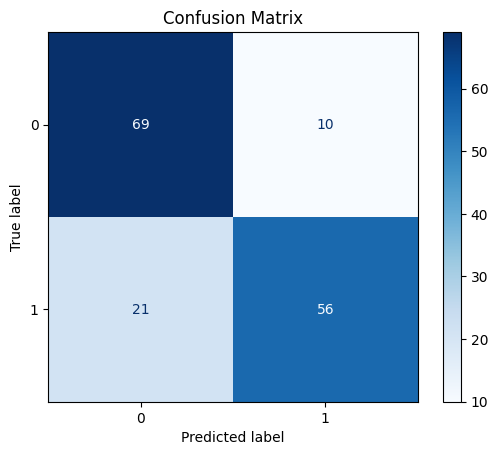

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 3. Basic metric
accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", accuracy)

# 4. Precision, Recall, F1-score (macro, micro, weighted)
print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# 5. Full classification report
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("📊 Confusion Matrix:\n", cm)

# 7. Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()